In [1]:
import os
from pathlib import Path

import librosa
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from pysimple.io import from_tsv

sb.set()

In [2]:
birds_path = Path(os.environ['DATA_DIR']) / 'birds' / 'birds.tsv'
birds = from_tsv(birds_path)
birds['gen_sp'] = birds['gen'] + '_' + birds['sp']
birds['name'] = birds['name'].str.split(',').str[0]

In [3]:
calls_dir = Path(os.environ['DATA_DIR']) / 'calls'

In [4]:
n_fft = 2048
hop_length = 512

S_mean = dict()
S_std = dict()

for _, bird in birds.head(10).iterrows():
    bird_name = bird['name']
    bird = bird['gen_sp']
    bird_dir = calls_dir / bird
    calls_paths = list(bird_dir.iterdir())
    print(f'There are {len(calls_paths)} calls for bird "{bird_name}"')
    
    S_mean[bird] = []
    S_std[bird] = []
    
    for i, call_path in enumerate(calls_paths[:10]):
        call, sr = librosa.load(call_path, sr=44100)

        # Trim silent edges
        call, _ = librosa.effects.trim(call)

        S = np.abs(librosa.stft(call, n_fft=n_fft, hop_length=hop_length))
        
        S_mean[bird].append(S.mean(axis=1).tolist())
        S_std[bird].append(S.std(axis=1).tolist())
    
    S_mean[bird] = np.array(S_mean[bird])
    S_std[bird] = np.array(S_std[bird])

There are 227 calls for bird "Боривітер звичайний"
There are 113 calls for bird "Підсоколик великий"
There are 294 calls for bird "Серпокрилець звичайний"
There are 1263 calls for bird "Дятел звичайний"
There are 78 calls for bird "Дятел сирійський"
There are 349 calls for bird "Ластівка міська"
There are 751 calls for bird "Шпак звичайний"
There are 421 calls for bird "Мухоловка сіра"
There are 477 calls for bird "Мухоловка мала"
There are 3356 calls for bird "Дрізд чорний"


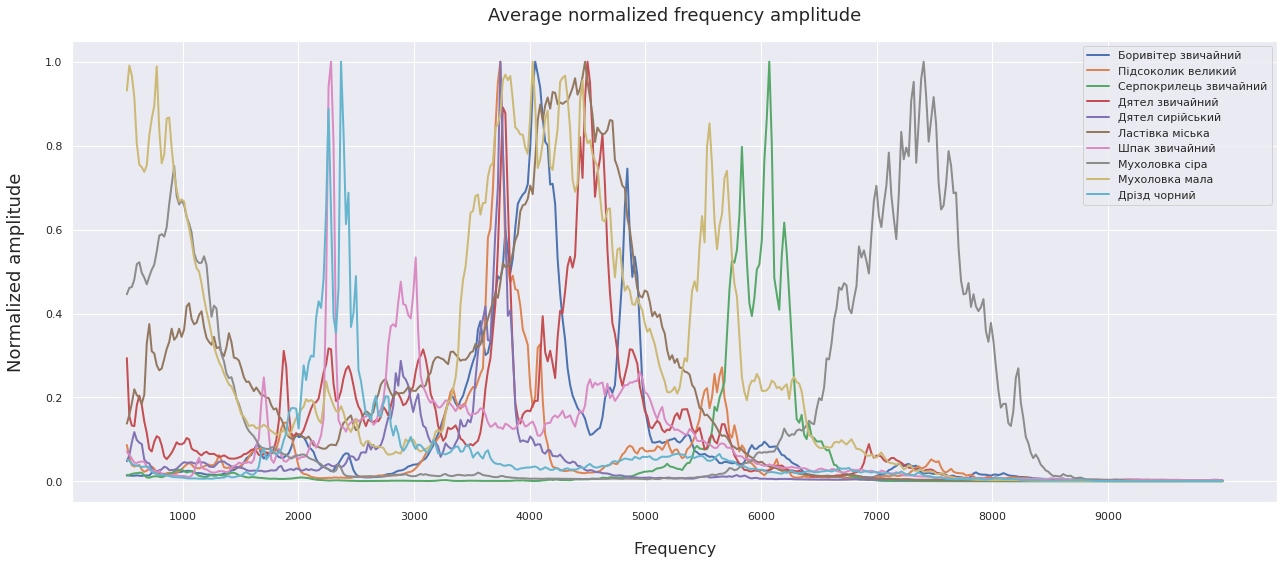

In [11]:
freqs = sr / n_fft * np.arange(n_fft / 2 + 1)

plt.figure(figsize=(18, 8))

for _, bird in birds.head(10).iterrows():
    bird_name = bird['name']
    bird = bird['gen_sp']
    
    S = S_mean[bird] * S_std[bird]
    # S = S.mean(axis=0) / S.std(axis=0)
    S = S.mean(axis=0)
    S = pd.Series(index=freqs, data=S)
    # Don't plot low and  high frequencies
    S = S[(S.index > 512) & (S.index < 10000)]
    # Normalize frequency, so that for every bird they fall into the same range
    S = S / S.max()
    S.plot(lw=2, label=bird_name)

plt.xticks(np.arange(1000, 10000, 1000))
plt.xlabel('Frequency', size=16, labelpad=20)
plt.ylabel('Normalized amplitude', size=18, labelpad=20)
plt.title('Average normalized frequency amplitude', size=18, pad=20)
plt.legend()
plt.tight_layout()
plt.show()